# Team: 
### Dawood - Hassam - Bilal

In [13]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import albumentations as A

c:\Users\Hassam\Documents\VS\DL_theory\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Hassam\Documents\VS\DL_theory\myenv\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + ".png"
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
def datasetLoad():
    # Transformations
    transform = T.Compose([
        T.Resize((224, 224)),  # ConvNeXt expects 224x224 input
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = APTOSDataset(
        csv_file="./datasetCCP/train_1.csv",
        image_dir="./datasetCCP/train_images",
        transform=transform
    )

    val_dataset = APTOSDataset(
        csv_file="./datasetCCP/valid.csv",
        image_dir="./datasetCCP/val_images",
        transform=transform
    )

    test_dataset = APTOSDataset(
        csv_file="./datasetCCP/test.csv",
        image_dir="./datasetCCP/test_images",
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    return train_loader,val_loader,test_loader
    

In [5]:
def prediction(model,image_path):
    model.eval()

    class_names = [
        "no DR", 
        "mild DR", 
        "moderate DR", 
        "severe DR", 
        "proliferative DR"
    ]

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()

    print(f"Predicted class: {class_names[predicted_class]}")


In [6]:
def evaluation(model, test):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    class_names = [
        "no DR", 
        "mild DR", 
        "moderate DR", 
        "severe DR", 
        "proliferative DR"]
    
    num_classes = len(class_names)

    with torch.no_grad():
        loop = tqdm(test, desc="Testing", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'Acc': f'{100 * correct / total:.2f}%'
            })

    # Metrics
    final_acc = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {final_acc * 100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Show 5 random images with predictions
    print("\nSample Predictions:")
    indices = random.sample(range(len(all_images)), 5)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image = all_images[idx]
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]

        # De-normalize
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.tight_layout()
    plt.show()

    # ROC Curve (One-vs-Rest)
    print("\nROC Curve:")
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [7]:
def convNextModel(epochs, num_classes, train, valid, dropout_rate=0.3):
    model = models.convnext_tiny(weights=True)

    # Replace the classifier with dropout added
    in_features = model.classifier[2].in_features
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.LayerNorm((in_features,)),
        nn.Dropout(dropout_rate),  # Dropout added here
        nn.Linear(in_features, num_classes)
    )
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    epoch_losses = []
    epoch_accuracies = []
    val_losses = []
    val_accuracies = []
    vram_usage = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train, desc=f"Epoch [{epoch+1}/{epochs}] Train", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'Loss': f'{running_loss / total:.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })

        epoch_loss = running_loss / len(train.dataset)
        epoch_acc = 100 * correct / len(train.dataset)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valid.dataset)
        val_acc = 100 * val_correct / len(valid.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if torch.cuda.is_available():
            mem_alloc = torch.cuda.memory_allocated(device) / (1024 ** 2)
            mem_reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
            print(f"VRAM allocated: {mem_alloc:.2f} MB, VRAM reserved: {mem_reserved:.2f} MB")
            vram_usage.append(mem_alloc)
        else:
            vram_usage.append(0)

    # Plot loss and accuracy
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, epoch_losses, 'r-', label='Train Loss')
    plt.plot(epochs_range, val_losses, 'g-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, epoch_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, 'm-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [23]:
train,valid,test = datasetLoad()

c:\Users\Hassam\Documents\VS\DL_theory\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.0218 Acc: 74.78% | Val Loss: 0.0168 Acc: 80.33%
VRAM allocated: 562.00 MB, VRAM reserved: 4268.00 MB


Epoch [2/10] Train Loss: 0.0135 Acc: 83.21% | Val Loss: 0.0154 Acc: 81.69%
VRAM allocated: 560.61 MB, VRAM reserved: 4860.00 MB


Epoch [3/10] Train Loss: 0.0097 Acc: 88.43% | Val Loss: 0.0153 Acc: 83.33%
VRAM allocated: 562.39 MB, VRAM reserved: 4860.00 MB


Epoch [4/10] Train Loss: 0.0065 Acc: 92.97% | Val Loss: 0.0158 Acc: 84.97%
VRAM allocated: 563.11 MB, VRAM reserved: 4860.00 MB


Epoch [5/10] Train Loss: 0.0036 Acc: 96.31% | Val Loss: 0.0173 Acc: 84.70%
VRAM allocated: 561.89 MB, VRAM reserved: 4860.00 MB


Epoch [6/10] Train Loss: 0.0027 Acc: 97.58% | Val Loss: 0.0190 Acc: 83.06%
VRAM allocated: 563.01 MB, VRAM reserved: 4860.00 MB


Epoch [7/10] Train Loss: 0.0021 Acc: 97.95% | Val Loss: 0.0191 Acc: 84.70%
VRAM allocated: 564.49 MB, VRAM reserved: 4860.00 MB


Epoch [8/10] Train Loss: 0.0018 Acc: 98.26% | Val Loss: 0.0206 Acc: 83.06%
VRAM allocated: 564.54 MB, VRAM reserved: 4860.00 MB


Epoch [9/10] Train Loss: 0.0019 Acc: 97.71% | Val Loss: 0.0193 Acc: 85.79%
VRAM allocated: 564.38 MB, VRAM reserved: 4860.00 MB


Epoch [10/10] Train Loss: 0.0017 Acc: 98.16% | Val Loss: 0.0211 Acc: 85.25%
VRAM allocated: 562.61 MB, VRAM reserved: 4860.00 MB


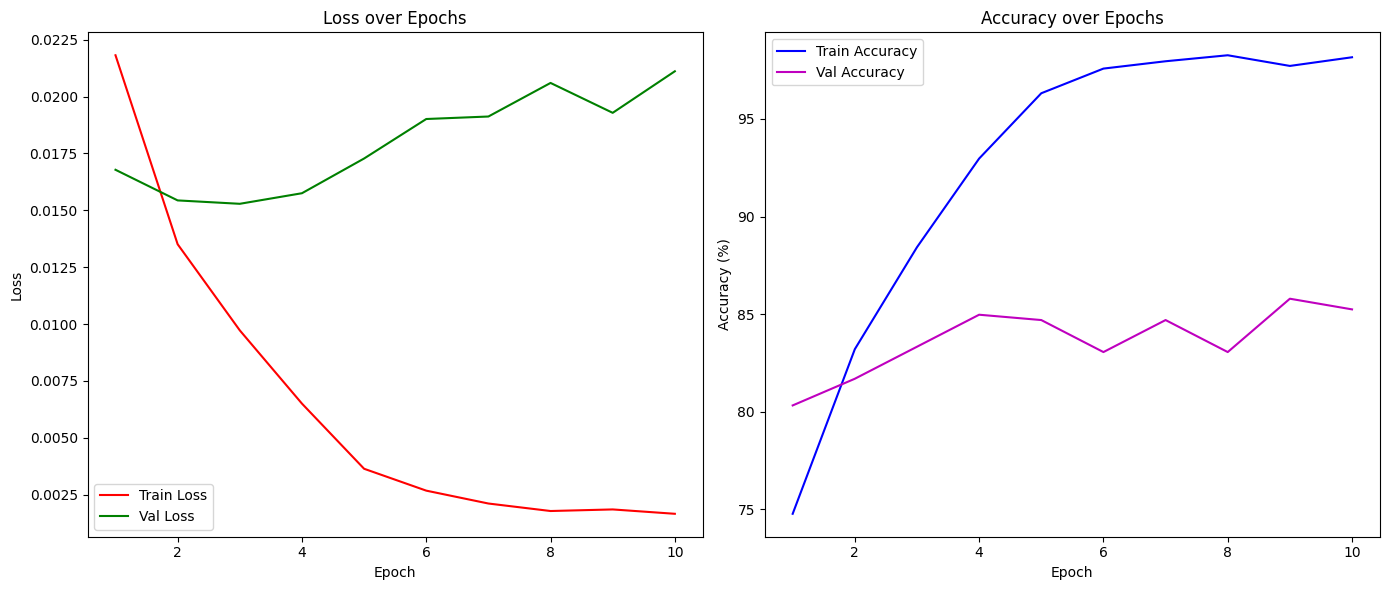

In [24]:
model=convNextModel(epochs=10,num_classes=5,train=train,valid=valid)

In [25]:
torch.save(model, 'modelconvnextA2-10.pth')

In [ ]:
model=torch.load("modelconvnextA2-10.pth",weights_only=False)

In [26]:
prediction(model,"./check3.png")

Predicted class: moderate DR



Test Accuracy: 84.15%

Classification Report:
                  precision    recall  f1-score   support

           no DR       0.98      0.98      0.98       199
         mild DR       0.64      0.53      0.58        30
     moderate DR       0.71      0.83      0.76        87
       severe DR       0.37      0.41      0.39        17
proliferative DR       0.89      0.52      0.65        33

        accuracy                           0.84       366
       macro avg       0.72      0.65      0.67       366
    weighted avg       0.85      0.84      0.84       366



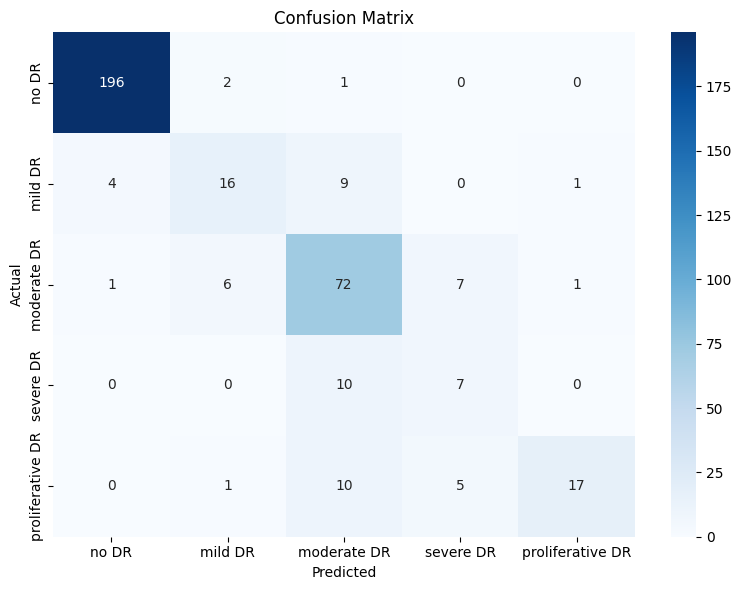


Sample Predictions:


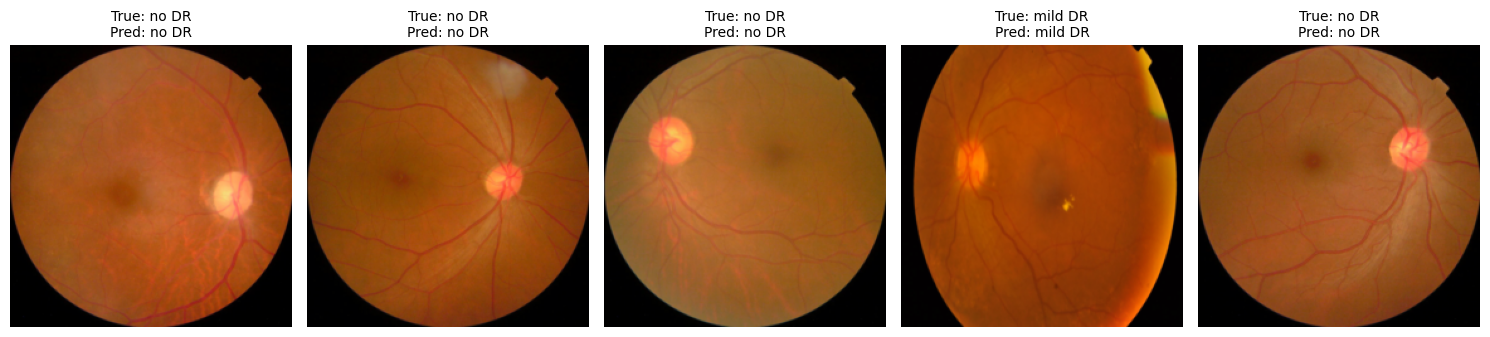


ROC Curve:


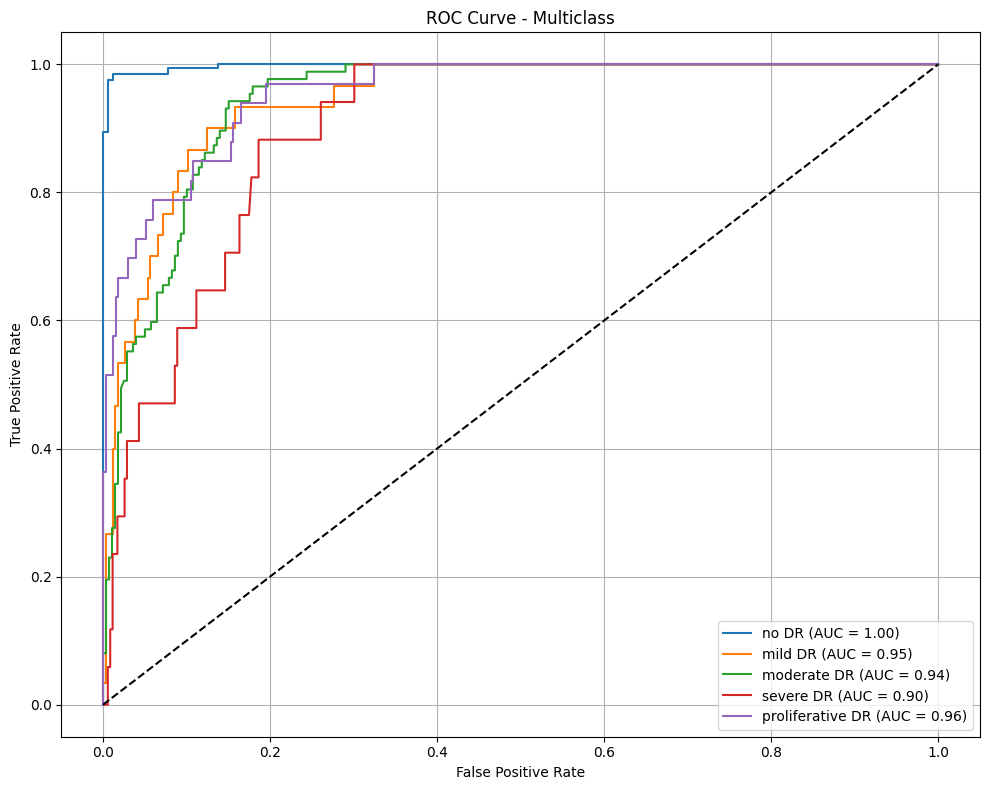

In [27]:
evaluation(model,test)